<a href="https://colab.research.google.com/github/ahzaidy/Programs/blob/main/CPSC_5410_HW1_U.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training with Dropout Rate: 0.3
Epoch 10/200, Loss: 0.6590, Learning Rate: 0.001000
Epoch 20/200, Loss: 0.3311, Learning Rate: 0.001000
Epoch 30/200, Loss: 0.3091, Learning Rate: 0.001000
Epoch 40/200, Loss: 0.2349, Learning Rate: 0.001000
Epoch 50/200, Loss: 0.2310, Learning Rate: 0.001000
Epoch 60/200, Loss: 0.2018, Learning Rate: 0.001000
Epoch 70/200, Loss: 0.1864, Learning Rate: 0.001000
Epoch 80/200, Loss: 0.2243, Learning Rate: 0.001000
Epoch 90/200, Loss: 0.1843, Learning Rate: 0.000500
Epoch 100/200, Loss: 0.1913, Learning Rate: 0.000250
Epoch 110/200, Loss: 0.1936, Learning Rate: 0.000125
Epoch 120/200, Loss: 0.1999, Learning Rate: 0.000125
Epoch 130/200, Loss: 0.1898, Learning Rate: 0.000125
Epoch 140/200, Loss: 0.1667, Learning Rate: 0.000063
Epoch 150/200, Loss: 0.1840, Learning Rate: 0.000063
Epoch 160/200, Loss: 0.1747, Learning Rate: 0.000031
Epoch 170/200, Loss: 0.1777, Learning Rate: 0.000016
Epoch 180/200, Loss: 0.1708, Learning Rate: 0.000008
Epoch 190/200, Loss: 0.

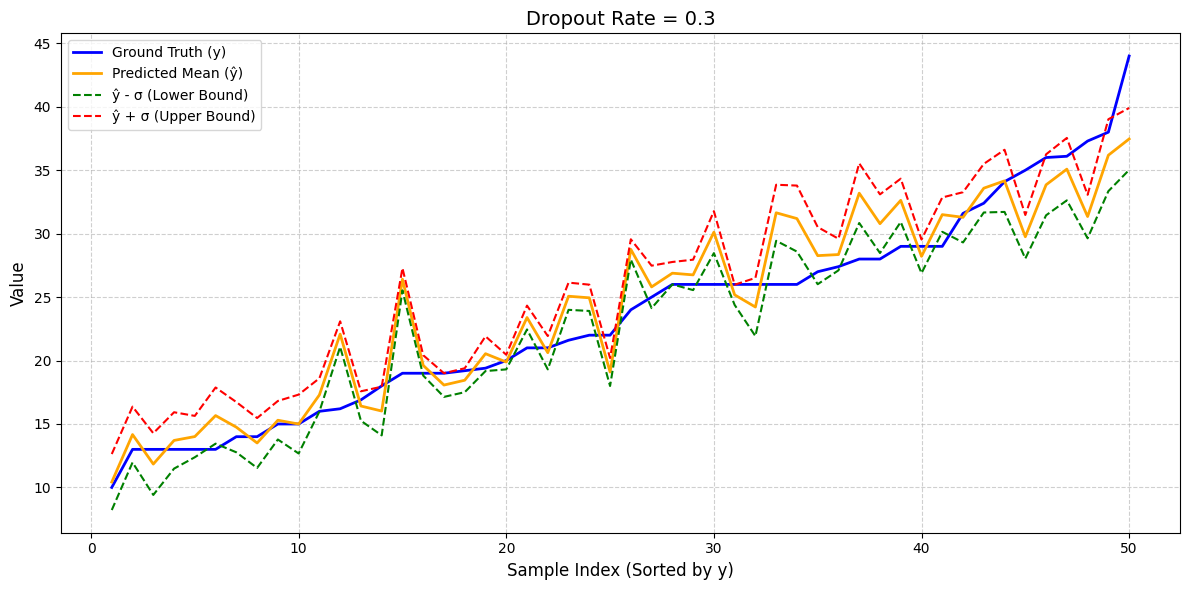

Training with Dropout Rate: 0.5
Epoch 10/200, Loss: 0.6502, Learning Rate: 0.001000
Epoch 20/200, Loss: 0.4167, Learning Rate: 0.001000
Epoch 30/200, Loss: 0.3644, Learning Rate: 0.001000
Epoch 40/200, Loss: 0.3420, Learning Rate: 0.001000
Epoch 50/200, Loss: 0.2879, Learning Rate: 0.001000
Epoch 60/200, Loss: 0.2952, Learning Rate: 0.001000
Epoch 70/200, Loss: 0.2759, Learning Rate: 0.000500
Epoch 80/200, Loss: 0.2923, Learning Rate: 0.000250
Epoch 90/200, Loss: 0.2879, Learning Rate: 0.000125
Epoch 100/200, Loss: 0.2648, Learning Rate: 0.000063
Epoch 110/200, Loss: 0.2449, Learning Rate: 0.000063
Epoch 120/200, Loss: 0.2556, Learning Rate: 0.000063
Epoch 130/200, Loss: 0.2627, Learning Rate: 0.000031
Epoch 140/200, Loss: 0.2561, Learning Rate: 0.000016
Epoch 150/200, Loss: 0.2458, Learning Rate: 0.000016
Epoch 160/200, Loss: 0.2901, Learning Rate: 0.000008
Epoch 170/200, Loss: 0.2376, Learning Rate: 0.000004
Epoch 180/200, Loss: 0.2748, Learning Rate: 0.000002
Epoch 190/200, Loss: 0.

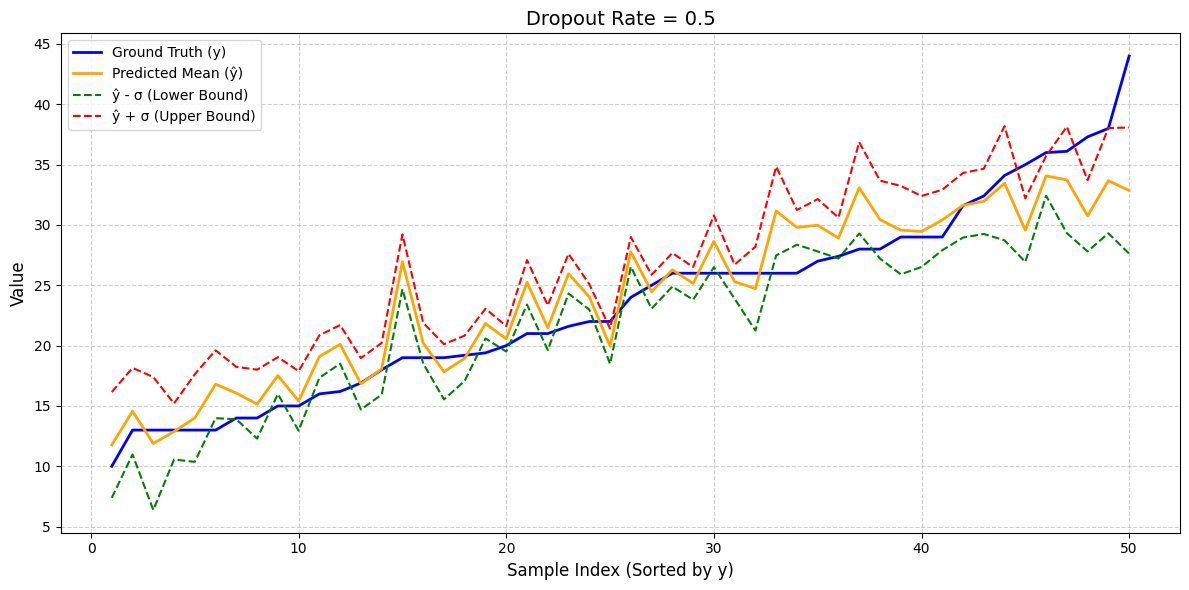

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

file_path = "https://raw.githubusercontent.com/ahzaidy/Programs/refs/heads/main/LibSVM-mpg.txt"

# Load the dataset using pandas
def load_data(file_path):
    data = pd.read_table(file_path, delim_whitespace=True, header=None)

    if data.shape[1] != 8:
        raise ValueError(f"Expected 8 columns (1 target + 7 features), but got {data.shape[1]} columns.")

    y = data.iloc[:, 0]  # Target (first column)
    X = data.iloc[:, 1:]  # Features (remaining columns)
    return X, y

# Define MLP model with Dropout
class MLPWithDropout(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(MLPWithDropout, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Train the model
def train_model(model, X_train, y_train, epochs, lr):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        if (epoch + 1) % 10 == 0:
            current_lr = scheduler.optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}, Learning Rate: {current_lr:.6f}")

# Monte-Carlo Dropout Testing
def monte_carlo_testing(model, X_test, num_passes):
    model.train()  # Keep dropout active during testing
    predictions = []

    for _ in range(num_passes):
        preds = model(X_test).detach().squeeze()
        predictions.append(preds.tolist())

    predictions_df = pd.DataFrame(predictions)
    means = predictions_df.mean(axis=0)
    stds = predictions_df.std(axis=0)

    for idx, std in stds.items():
        print(f"Sample {idx + 1}: Standard Deviation = {std:.4f}")

    return means, stds

# Plot the results
def plot_results(y_true, y_mean, y_std, title):
    sorted_indices = y_true.sort_values().index
    y_true_sorted = y_true.loc[sorted_indices]
    y_mean_sorted = y_mean.loc[sorted_indices]
    y_std_sorted = y_std.loc[sorted_indices]

    lower_bound = y_mean_sorted - y_std_sorted
    upper_bound = y_mean_sorted + y_std_sorted

    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(y_true_sorted) + 1), y_true_sorted, label="Ground Truth (y)", color="blue", linewidth=2)
    plt.plot(range(1, len(y_mean_sorted) + 1), y_mean_sorted, label="Predicted Mean (ŷ)", color="orange", linewidth=2)
    plt.plot(range(1, len(lower_bound) + 1), lower_bound, label="ŷ - σ (Lower Bound)", linestyle="--", color="green", linewidth=1.5)
    plt.plot(range(1, len(upper_bound) + 1), upper_bound, label="ŷ + σ (Upper Bound)", linestyle="--", color="red", linewidth=1.5)

    plt.legend(loc="upper left", fontsize=10)
    plt.xlabel("Sample Index (Sorted by y)", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Main script
if __name__ == "__main__":
    try:
        # Load data
        X, y = load_data(file_path)

        # Normalize features and target
        scaler_X = StandardScaler()
        X = pd.DataFrame(scaler_X.fit_transform(X))

        scaler_y = StandardScaler()
        y = pd.Series(scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten())

        # Split dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=50, random_state=42, shuffle=True)

        # Convert Pandas DataFrame to PyTorch tensors
        X_train = torch.tensor(X_train.values, dtype=torch.float32)
        X_test = torch.tensor(X_test.values, dtype=torch.float32)
        y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
        y_test = torch.tensor(y_test.values, dtype=torch.float32)

        # Train and test for dropout rates 0.3 and 0.5
        for dropout_rate in [0.3, 0.5]:
            print(f"Training with Dropout Rate: {dropout_rate}")
            model = MLPWithDropout(input_size=7, hidden_size=64, dropout_rate=dropout_rate)
            train_model(model, X_train, y_train, epochs=200, lr=0.001)

            # Perform Monte-Carlo Dropout Testing
            y_mean, y_std = monte_carlo_testing(model, X_test, num_passes=10)

            # Convert predictions back to original scale
            y_test_original = pd.Series(scaler_y.inverse_transform(y_test.view(-1, 1)).flatten())
            y_mean_original = pd.Series(scaler_y.inverse_transform(y_mean.values.reshape(-1, 1)).flatten())
            y_std_original = pd.Series(
                scaler_y.inverse_transform((y_mean.values + y_std.values).reshape(-1, 1)).flatten() - y_mean_original
            )

            # Plot results
            plot_results(y_test_original, y_mean_original, y_std_original, title=f"Dropout Rate = {dropout_rate}")

    except Exception as e:
        print(f"Error: {e}")
